# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.2.0


## Ошибки без следующих строк:

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Загружаем разметку

In [24]:
import os
import json
from glob import glob

TRAIN_PREFIX = "data/fish/train"

def load_annotations():
    boxes = dict()
    for path in glob('data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
            if rect['class']:
                cv2.putText(img, rect['class'], (int(rect['x']), int(rect['y'])+5), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [25]:
boxes = load_annotations()  # загружаем разметку детекций

In [26]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,alb,1719
1,bet,200
2,dol,117
3,lag,67
4,shark,176
5,yft,734


**Классы явно не сбалансированы**

Инициализация ван хот енкодера

In [27]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
fish_class = []
for c in boxes.keys():
    fish_class.append([c])

# Почему то в лейблинге нет класса other, а мне не хочется заниматься разметкой
#fish_class.append(['other'])
#fish_class.append(['background'])
ohe.fit(fish_class)

# сколько выходов на классы
CLASS_COUNT = len(fish_class)

**Запишем класс внутрь значения, чтобы поменьше менять в генераторе**

In [28]:
for key, value in boxes.items():
    for v in value:
        v['class'] = key

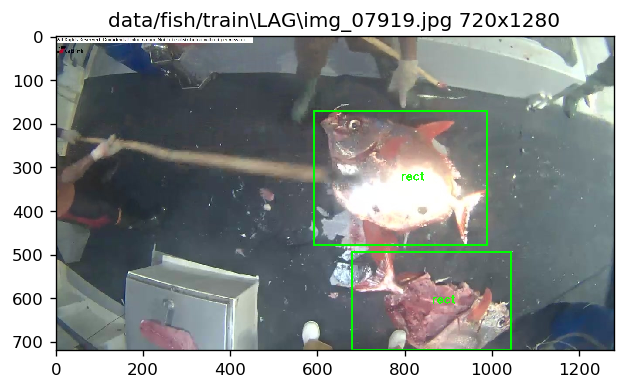

In [29]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

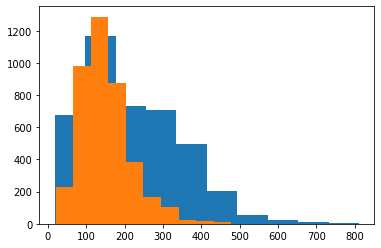

In [30]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [31]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

# сколько выходов на сетку
BOUND_COUNT = 5 
OUTPUT_COUNT = BOUND_COUNT + CLASS_COUNT
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [32]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [33]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    global ohe
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], OUTPUT_COUNT), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        # какой класс
        class_code = ohe.transform([[annotation['class']]]).toarray()
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = np.hstack([[1., dx, dy, dw, dh], class_code[0]])
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col][:BOUND_COUNT]
            
            class_predicted = prediction[row, col][BOUND_COUNT:]
            # находим максимальную веростность
            prob = np.argmax(class_predicted)
            
            if class_predicted[prob] > conf_thr:
                class_predicted = ohe.categories_[0][prob]
            else:
                class_predicted = 'OTHER'
            
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf, 
                                   'class':class_predicted
                                  })
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

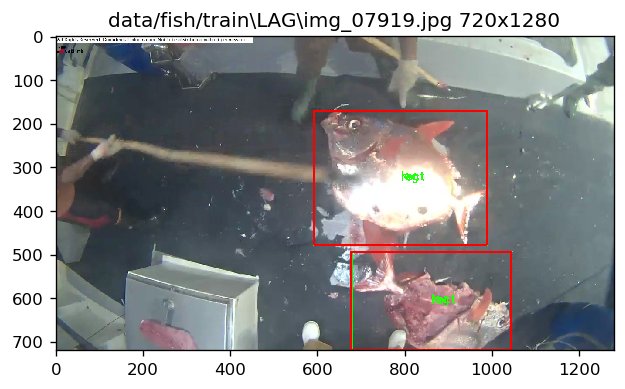

In [34]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [40]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss


def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)


# classification loss function
def log_loss(y, prediction):
    y = tf.convert_to_tensor(y)
    loss = y * tf.math.log(prediction)
    loss += (1. - y) * tf.math.log(1. - prediction)
    return - tf.reduce_mean(loss)

def closs(y_true, y_pred):
    return log_loss(y_true[..., :BOUND_COUNT], y_pred[..., :BOUND_COUNT])


def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    y_true = K.reshape(y_true, (batch_size, -1, OUTPUT_COUNT))
    y_pred = K.reshape(y_pred, (batch_size, -1, OUTPUT_COUNT))   
   
    class_loss = closs(y_true, y_pred)   

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    # Корректно ли суммировать ошибку по рамке и классам?
    return class_loss + total_conf_loss + 0.5 * loc_loss

## Загрузка данных

In [41]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    # one hot encoding transformer
    global ohe
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                y_boxes = encode_anchors(boxes[j], img_shape) 
                y.append(y_boxes)
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [42]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)


output = tf.keras.layers.Conv2D(OUTPUT_COUNT,
                                kernel_size=(1, 1), 
                                activation='sigmoid',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 750, 1200, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128)     0   

## Обучение

In [43]:
adam = tf.keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss, closs])

In [44]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=500)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          callbacks=[checkpoint])

Epoch 1/100
499/602 [=======================>......] - ETA: 29s - loss: 1.4084 - confidence_loss: 0.7670 - closs: 0.2007
Epoch 00001: loss improved from inf to 1.40763, saving model to fishdetector.hdf5
603/602 [==============================] - 173s 287ms/step - loss: 1.3557 - confidence_loss: 0.7564 - closs: 0.1736
Epoch 2/100
396/602 [==================>...........] - ETA: 1:04 - loss: 1.0452 - confidence_loss: 0.7027 - closs: 0.0331
Epoch 00002: loss improved from 1.40763 to 1.04483, saving model to fishdetector.hdf5
603/602 [==============================] - 194s 322ms/step - loss: 1.0402 - confidence_loss: 0.7020 - closs: 0.0306
Epoch 3/100
293/602 [=============>................] - ETA: 1:45 - loss: 1.0072 - confidence_loss: 0.6994 - closs: 0.0222
Epoch 00003: loss improved from 1.04483 to 1.00674, saving model to fishdetector.hdf5
603/602 [==============================] - 207s 343ms/step - loss: 1.0014 - confidence_loss: 0.6990 - closs: 0.0207
Epoch 4/100
190/602 [========>...

527/602 [=========================>....] - ETA: 28s - loss: 0.9322 - confidence_loss: 0.6940 - closs: 0.0041
Epoch 00025: loss did not improve from 0.90475
603/602 [==============================] - 228s 379ms/step - loss: 0.9326 - confidence_loss: 0.6940 - closs: 0.0041
Epoch 26/100
424/602 [====================>.........] - ETA: 1:08 - loss: 0.9265 - confidence_loss: 0.6940 - closs: 0.0040
Epoch 00026: loss did not improve from 0.90475
603/602 [==============================] - 231s 383ms/step - loss: 0.9287 - confidence_loss: 0.6940 - closs: 0.0040
Epoch 27/100
321/602 [==============>...............] - ETA: 1:44 - loss: 0.9300 - confidence_loss: 0.6940 - closs: 0.0040
Epoch 00027: loss did not improve from 0.90475
603/602 [==============================] - 227s 376ms/step - loss: 0.9327 - confidence_loss: 0.6940 - closs: 0.0040
Epoch 28/100
218/602 [=========>....................] - ETA: 2:25 - loss: 0.9314 - confidence_loss: 0.6940 - closs: 0.0038
Epoch 00028: loss did not improve

Epoch 51/100
349/602 [================>.............] - ETA: 1:37 - loss: 0.9251 - confidence_loss: 0.6939 - closs: 0.0029
Epoch 00051: loss did not improve from 0.90475
603/602 [==============================] - 230s 381ms/step - loss: 0.9297 - confidence_loss: 0.6939 - closs: 0.0029
Epoch 52/100
246/602 [===========>..................] - ETA: 2:14 - loss: 0.9292 - confidence_loss: 0.6939 - closs: 0.0030
Epoch 00052: loss did not improve from 0.90475
603/602 [==============================] - 228s 378ms/step - loss: 0.9294 - confidence_loss: 0.6939 - closs: 0.0029
Epoch 53/100
143/602 [======>.......................] - ETA: 2:54 - loss: 0.9286 - confidence_loss: 0.6939 - closs: 0.0031
Epoch 00053: loss did not improve from 0.90475
603/602 [==============================] - 230s 382ms/step - loss: 0.9253 - confidence_loss: 0.6939 - closs: 0.0029
Epoch 54/100
 40/602 [>.............................] - ETA: 3:32 - loss: 0.9460 - confidence_loss: 0.6939 - closs: 0.0030
Epoch 00054: loss d

603/602 [==============================] - 206s 342ms/step - loss: 0.9293 - confidence_loss: 0.6939 - closs: 0.0022
Epoch 77/100
171/602 [=======>......................] - ETA: 2:20 - loss: 0.9387 - confidence_loss: 0.6939 - closs: 0.0020
Epoch 00077: loss did not improve from 0.90417
603/602 [==============================] - 202s 334ms/step - loss: 0.9286 - confidence_loss: 0.6939 - closs: 0.0022
Epoch 78/100
 68/602 [==>...........................] - ETA: 2:57 - loss: 0.9232 - confidence_loss: 0.6940 - closs: 0.0026
Epoch 00078: loss did not improve from 0.90417
568/602 [===========================>..] - ETA: 11s - loss: 0.9246 - confidence_loss: 0.6939 - closs: 0.0023
Epoch 00078: loss did not improve from 0.90417
603/602 [==============================] - 205s 340ms/step - loss: 0.9260 - confidence_loss: 0.6939 - closs: 0.0023
Epoch 79/100
 37/602 [>.............................] - ETA: 3:08 - loss: 0.9187 - confidence_loss: 0.6938 - closs: 0.0026

KeyboardInterrupt: 

## Результат работы детектора

In [ ]:
model.load_weights('fishdetector.hdf5')

[{'x': 16.162355660580452, 'y': 16.29225338264128, 'width': 149.99999035000934, 'height': 149.9686288567318, 'conf': 0.500370404138219, 'class': 'alb'}, {'x': 145.8920853903102, 'y': 16.29225338264128, 'width': 149.99999035000934, 'height': 149.9686288567318, 'conf': 0.500370404138219, 'class': 'alb'}, {'x': 275.6218151200399, 'y': 16.29225338264128, 'width': 149.99999035000934, 'height': 149.9686288567318, 'conf': 0.500370404138219, 'class': 'alb'}, {'x': 405.35154484976965, 'y': 16.29225338264128, 'width': 149.99999035000934, 'height': 149.9686288567318, 'conf': 0.500370404138219, 'class': 'alb'}, {'x': 535.0812745794994, 'y': 16.29225338264128, 'width': 149.99999035000934, 'height': 149.9686288567318, 'conf': 0.500370404138219, 'class': 'alb'}]


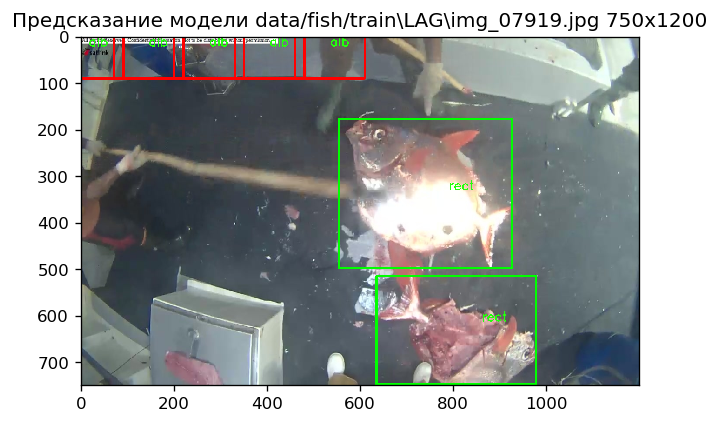

In [45]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

print(decoded)
plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {} {}x{}'.format(annotation['filename'],*img.shape));

## Визуализируем предсказание на тесте

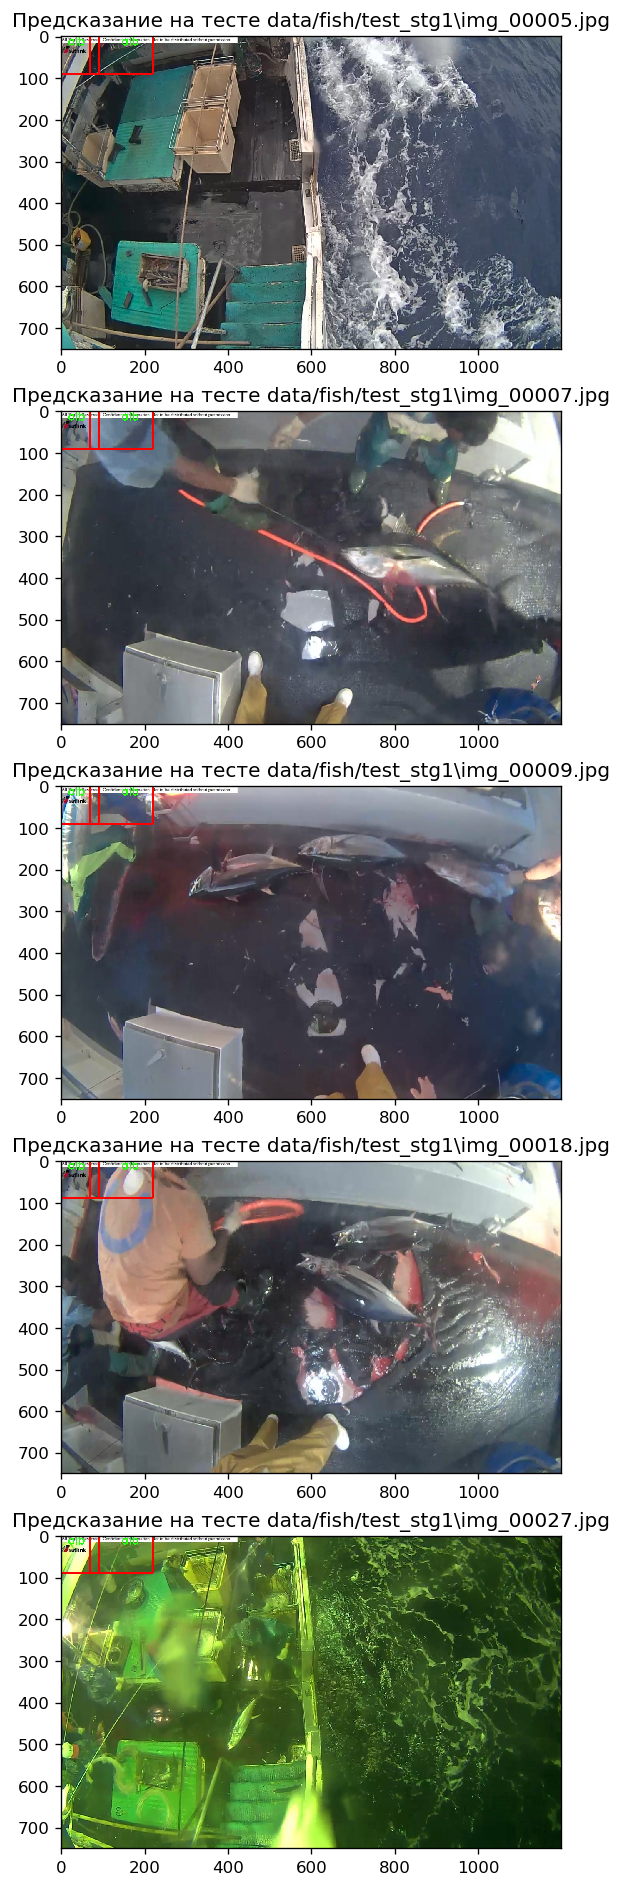

In [46]:
%matplotlib inline
test_images = glob('data/fish/test_stg1/*.jpg')[:5]

plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0